# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import json
import requests
import numpy as np

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_2 = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
df_3 = pd.read_csv('image_predictions.tsv', sep='\t' )

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
"""
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
"""
# open json file
f = open('tweet_json.txt')

# read json file line by line 
lines = f.readlines()

# close file
f.close()

# declaring json array variable
data = []
for line in lines:
    json_row = json.loads(line)  # convert line to json object
    data.append(json_row) # append json object to json array

# converting array of json to data frame
df = pd.DataFrame.from_dict(data)

df_1 = df[['id','retweet_count','favorite_count']].copy()



## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Visual Assessment 

I opened the flat files in a .csv to visually inspect the content and structure of the data frames as well as programmatically assess the three data frames.

In [5]:
df_1.to_csv("tweet_json_df.csv")

In [6]:
df_1

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [7]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [9]:
df_2

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
df_3

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
df_1.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


### Tidiness issues
1. Column name "id" in the df_1 does not match the other column "tweet_id".

2. df_1 (the dataframe for tweet_json) has 2354 rows and df_2 (the df for twitter_archive_enhanced) has 2356 rows and df_3 (the df for image_predictions) has 2075 rows. There are consistency issues relating to number of rows and tweet_ids that are associated with actual images. Number of rows are constrained to tweet_id that actually have pictures (jpg_url) associated with them.

3. Column names in image_predictions (df_3) are not descriptive. They are poorly worded.

### Quality issues (dirt is stuff that does not belong)


1. Missing expanded_urls and other data in the twitter_archive_enhanced related dataframe portion.

2. There are records where the denomenator is zero or some number other than 10

3. There are duplicate data in several columns in the image_predictions related columns (df_3)

4. The in_reply_to_user_id and in_reply_to_status_id columns are irrelevant

5. retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns are irrelevant.

6. doggo, floofer, pupper, puppo columns are irrelevant for analysis.

7. 'jpg_url', 'timestamp', 'source', 'text', 'expanded_urls' should ultimately be dropped since they will not be used in the analysis.

8. Datatypes need to stay consistent

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [13]:
# creating an original df which will be compared to after cleaning activities are completed.
tweet_json_df = df_1.copy()   #2354
twitter_archive_enhanced_df = df_2.copy()  #2356
image_predictions_df = df_3.copy()


### Tidiness Issue #1: Rename "id" to "tweet_id"

#### Define:
Column name "id" in the df_1 does not match the other identification column "tweet_id" in the other dataframes. The column needs to be renamed to "tweet_id" for consistency purposes and to allow a joining of data with the primary key being "tweet_id".

#### Code

In [14]:
tweet_json_df.rename(columns = {'id':'tweet_id'}, inplace = True)

#### Test

In [15]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


### Tidiness Issue #2: Exclude all rows with tweet_ids not associated with actual images

#### Define: 
Merge the dataframes together and only on those twitter ids that have pictures associated with them.

#### Code

In [16]:
tweet_json_df = tweet_json_df.merge(twitter_archive_enhanced_df.drop_duplicates(), on= 'tweet_id', how= 'left')
master_df = image_predictions_df.merge(tweet_json_df.drop_duplicates(), on= 'tweet_id', how= 'left')

#### Test

In [17]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
tweet_id                      2075 non-null int64
jpg_url                       2075 non-null object
img_num                       2075 non-null int64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        2075 non-null bool
p2                            2075 non-null object
p2_conf                       2075 non-null float64
p2_dog                        2075 non-null bool
p3                            2075 non-null object
p3_conf                       2075 non-null float64
p3_dog                        2075 non-null bool
retweet_count                 2073 non-null float64
favorite_count                2073 non-null float64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2

### Tidiness Issue #3: Make predictive column names more descriptive

#### Define: 
Change column names relating to pedictive data element fields.

#### Code

In [18]:
#rename the column names to more descriptive names
master_df.rename(columns = {'img_num':'image_count', 'p1':'prediction1', 'p1_conf':'prediction1_confidence', 'p1_dog':'prediction1_is_dog', 'p2':'prediction2', 'p2_conf':'prediction2_confidence', 'p2_dog':'prediction2_is_dog', 'p3':'prediction3','p3_conf':'prediction3_confidence','p3_dog':'prediction3_is_dog'}, inplace= True)

#### Test

In [19]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
tweet_id                      2075 non-null int64
jpg_url                       2075 non-null object
image_count                   2075 non-null int64
prediction1                   2075 non-null object
prediction1_confidence        2075 non-null float64
prediction1_is_dog            2075 non-null bool
prediction2                   2075 non-null object
prediction2_confidence        2075 non-null float64
prediction2_is_dog            2075 non-null bool
prediction3                   2075 non-null object
prediction3_confidence        2075 non-null float64
prediction3_is_dog            2075 non-null bool
retweet_count                 2073 non-null float64
favorite_count                2073 non-null float64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2

### Quality Issue #1: expanded_urls and other data is missing in two rows

#### Define: 
Find the two rows which is missing expanded_urls and other data. Once found, delete the two rows.

#### Code

In [20]:
master_df[master_df['expanded_urls'].isna()]

,tweet_id,jpg_url,image_count,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1413,771004394259247104,https://pbs.twimg.com/media/CrMmVqyWcAIDCHI.jpg,1,home_theater,0.414338,False,iPod,0.052741,False,pop_bottle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
tweet_id_index = master_df[(master_df['tweet_id']== 771004394259247104)|(master_df['tweet_id']== 888202515573088257)].index
master_df.drop(tweet_id_index, inplace= True)

#### Test

In [22]:
master_df[master_df['expanded_urls'].isna()]

,tweet_id,jpg_url,image_count,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Quality Issue #2: Denominator inconsistencies

#### Define: 
There are records where the rating_denomenator has a value of zero or some number other than 10. Find all of the records where the denominator is not 10 and change it to 10.

#### Code

In [23]:
master_df[master_df.rating_denominator!=10.0]

,tweet_id,jpg_url,image_count,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
20,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,...,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1.0,2.0,an,None,None,None,None
501,675853064436391936,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,1,Labrador_retriever,0.868367,True,golden_retriever,0.043305,True,vizsla,...,NaN,NaN,https://twitter.com/dog_rates/status/675853064...,88.0,80.0,None,None,None,None,None
560,677716515794329600,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,1,teddy,0.662908,False,crib,0.031891,False,chow,...,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144.0,120.0,None,None,None,None,None
667,682962037429899265,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1,dingo,0.278600,False,Chihuahua,0.155207,True,loupe,...,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7.0,11.0,Darrel,None,None,None,None
692,684222868335505415,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,1,soft-coated_wheaten_terrier,0.791182,True,cocker_spaniel,0.072444,True,teddy,...,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121.0,110.0,None,None,None,None,None
693,684225744407494656,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,golden_retriever,0.203249,True,Samoyed,0.067958,True,Great_Pyrenees,...,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143.0,130.0,None,None,None,None,None
865,697463031882764288,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,...,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44.0,40.0,None,None,None,None,None
941,704054845121142784,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,1,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,...,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60.0,50.0,a,None,None,None,None
1007,709198395643068416,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,...,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45.0,50.0,None,None,None,None,None
1025,710658690886586372,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,...,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80.0,80.0,None,None,None,None,None


In [24]:
master_df['rating_denominator'] = np.where(master_df['rating_denominator'] != 10.0, 10.0, 10.0)
#master_df.rating_denominator.replace(to_replace=  , value= 0, inplace= True)

#### Test

In [25]:
master_df[master_df.rating_denominator!=10.0]

,tweet_id,jpg_url,image_count,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [26]:
master_df.rating_denominator.describe()

count    2073.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: rating_denominator, dtype: float64

### Quality Issue #3: Duplicate data 

### Define: 
Find and delete duplicate data related rows. 

### Code

In [27]:
tweet_ids_delete_df = master_df[master_df['jpg_url'].duplicated()]
tweet_ids_delete =tweet_ids_delete_df['tweet_id']
master_df = master_df[master_df.tweet_id.isin(tweet_ids_delete) == False]

### Test

In [28]:
master_df[master_df['jpg_url'].duplicated()]

,tweet_id,jpg_url,image_count,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [29]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2074
Data columns (total 30 columns):
tweet_id                      2008 non-null int64
jpg_url                       2008 non-null object
image_count                   2008 non-null int64
prediction1                   2008 non-null object
prediction1_confidence        2008 non-null float64
prediction1_is_dog            2008 non-null bool
prediction2                   2008 non-null object
prediction2_confidence        2008 non-null float64
prediction2_is_dog            2008 non-null bool
prediction3                   2008 non-null object
prediction3_confidence        2008 non-null float64
prediction3_is_dog            2008 non-null bool
retweet_count                 2008 non-null float64
favorite_count                2008 non-null float64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2008 non-null object
source                        2

### Quality Issue #4 & #5: remove columns "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"

#### Define:
remove columns "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp". They have numerous missing data and are not relevant to analysis that is being conducted.

#### Code

In [31]:
master_df.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [32]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2074
Data columns (total 25 columns):
tweet_id                  2008 non-null int64
jpg_url                   2008 non-null object
image_count               2008 non-null int64
prediction1               2008 non-null object
prediction1_confidence    2008 non-null float64
prediction1_is_dog        2008 non-null bool
prediction2               2008 non-null object
prediction2_confidence    2008 non-null float64
prediction2_is_dog        2008 non-null bool
prediction3               2008 non-null object
prediction3_confidence    2008 non-null float64
prediction3_is_dog        2008 non-null bool
retweet_count             2008 non-null float64
favorite_count            2008 non-null float64
timestamp                 2008 non-null object
source                    2008 non-null object
text                      2008 non-null object
expanded_urls             2008 non-null object
rating_numerator          2008 non-null float64
ra

### Quality Issue #6: Remove "doggo", "floofer", "pupper", "puppo"

#### Define:
The "doggo", "floofer", "pupper", and "puppo" columns and the data representation are not relevant for this analysis and there are a majority of "Null" values. Remove the "doggo", "floofer", "pupper", and "puppo" columns.

#### Code

In [33]:
master_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis= 1, inplace=True)

#### Test

In [35]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2074
Data columns (total 21 columns):
tweet_id                  2008 non-null int64
jpg_url                   2008 non-null object
image_count               2008 non-null int64
prediction1               2008 non-null object
prediction1_confidence    2008 non-null float64
prediction1_is_dog        2008 non-null bool
prediction2               2008 non-null object
prediction2_confidence    2008 non-null float64
prediction2_is_dog        2008 non-null bool
prediction3               2008 non-null object
prediction3_confidence    2008 non-null float64
prediction3_is_dog        2008 non-null bool
retweet_count             2008 non-null float64
favorite_count            2008 non-null float64
timestamp                 2008 non-null object
source                    2008 non-null object
text                      2008 non-null object
expanded_urls             2008 non-null object
rating_numerator          2008 non-null float64
ra

### Quality Issue #7: Remove irrelevant columns

#### Define:
Remove the columns which hold no significance in the analysis.

#### Code

In [31]:
master_df.drop(['jpg_url', 'timestamp', 'source', 'text', 'expanded_urls'], axis= 1, inplace=True)

#### Test

In [32]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2074
Data columns (total 16 columns):
tweet_id                  2008 non-null int64
image_count               2008 non-null int64
prediction1               2008 non-null object
prediction1_confidence    2008 non-null float64
prediction1_is_dog        2008 non-null bool
prediction2               2008 non-null object
prediction2_confidence    2008 non-null float64
prediction2_is_dog        2008 non-null bool
prediction3               2008 non-null object
prediction3_confidence    2008 non-null float64
prediction3_is_dog        2008 non-null bool
retweet_count             2008 non-null float64
favorite_count            2008 non-null float64
rating_numerator          2008 non-null float64
rating_denominator        2008 non-null float64
name                      2008 non-null object
dtypes: bool(3), float64(7), int64(2), object(4)
memory usage: 225.5+ KB


### Quality Issue #8: Data Type Integrity

#### Define:
The datatypes for "retweet_count", "favorite_count", "rating_numerator" and "rating_denominator" have changed from integer to float while conducting cleaning activites. Restore the original data types to the mentioned columns.

#### Code

In [36]:
#this is getting the retweet_count, favorite_count, rating_numerator, and rating_denominator back to integer data-type
master_df['retweet_count'] = master_df['retweet_count'].astype(int)
master_df['favorite_count'] = master_df['favorite_count'].astype(int)
master_df['rating_numerator'] = master_df['rating_numerator'].astype(int)
master_df['rating_denominator'] = master_df['rating_denominator'].astype(int)

#### Test

In [37]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 0 to 2074
Data columns (total 21 columns):
tweet_id                  2008 non-null int64
jpg_url                   2008 non-null object
image_count               2008 non-null int64
prediction1               2008 non-null object
prediction1_confidence    2008 non-null float64
prediction1_is_dog        2008 non-null bool
prediction2               2008 non-null object
prediction2_confidence    2008 non-null float64
prediction2_is_dog        2008 non-null bool
prediction3               2008 non-null object
prediction3_confidence    2008 non-null float64
prediction3_is_dog        2008 non-null bool
retweet_count             2008 non-null int64
favorite_count            2008 non-null int64
timestamp                 2008 non-null object
source                    2008 non-null object
text                      2008 non-null object
expanded_urls             2008 non-null object
rating_numerator          2008 non-null int64
rating_d

In [35]:
master_df.head(3)

,tweet_id,image_count,prediction1,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,prediction3_confidence,prediction3_is_dog,retweet_count,favorite_count,rating_numerator,rating_denominator,name
0,666020888022790149,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,532,2535,8,10,None
1,666029285002620928,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,48,132,7,10,a
2,666033412701032449,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,47,128,9,10,a


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [38]:
master_df.to_csv("twitter_archive_master.csv")

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [39]:
median_retweet = master_df.retweet_count.median()
low = master_df.query('retweet_count < {}'.format(median_retweet))
high = master_df.query('retweet_count >= {}'.format(median_retweet))
mean_retweet_low = low.retweet_count.mean()
mean_retweet_high = high.retweet_count.mean()

In [40]:
print("average number for lower half retweet = ", mean_retweet_low)
print("average number for upper half retweet = ", mean_retweet_high)


average number for lower half retweet =  642.375498008
average number for upper half retweet =  4855.15338645


In [41]:
print(mean_retweet_high/mean_retweet_low)

7.55812356092


In [42]:
master_df.describe()

,tweet_id,image_count,prediction1_confidence,prediction2_confidence,prediction3_confidence,retweet_count,favorite_count,rating_numerator,rating_denominator
count,2.008000e+03,2008.000000,2008.000000,2.008000e+03,2.008000e+03,2008.000000,2008.000000,2008.000000,2008.0
mean,7.363173e+17,1.202689,0.594557,1.341132e-01,6.017627e-02,2748.764442,8833.703685,12.277888,10.0
std,6.772918e+16,0.559604,0.272274,1.006481e-01,5.086572e-02,4663.351719,12193.020613,41.353212,0.0
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10,16.000000,0.000000,0.000000,10.0
25%,6.758663e+17,1.000000,0.362903,5.378615e-02,1.609288e-02,618.000000,1896.000000,10.000000,10.0
50%,7.088401e+17,1.000000,0.588620,1.170625e-01,4.947920e-02,1342.000000,4072.000000,11.000000,10.0
75%,7.888015e+17,1.000000,0.847560,1.949772e-01,9.157912e-02,3190.750000,11256.500000,12.000000,10.0
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01,79515.000000,132810.000000,1776.000000,10.0


### Insights:
1. For retweet_counts in the upper 50% of master_df. They receive more than seven times the amount of retweets on average than the bottom 50%. 

2. Reteweet counts are right skewd according to the code master_df.describe() where the standard deviation is 4663 and the 75 percentile is 3190.

3. The favorit_count is usually higher than the reweet_count. 

### Visualization

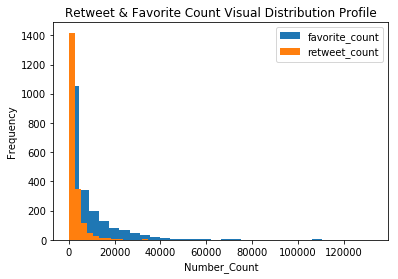

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
master_df['favorite_count'].plot(kind='hist', bins= 30)

master_df['retweet_count'].plot(kind='hist',bins= 30,  title= 'Retweet & Favorite Count Visual Distribution Profile')
plt.xlabel('Number_Count')
plt.legend()